# 1. Load Library

In [112]:
!pip install xlsxwriter

In [113]:
# Xử lý thời gian và dữ liệu
from datetime import datetime
import pandas as pd
import numpy as np
import io

# Cluster Library
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

# Làm việc với Google Sheets
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

# Làm việc với Excel
import xlsxwriter
from openpyxl.drawing.image import Image

# Cài đặt hiển thị rộng hơn cho DataFrame
pd.set_option('display.width', 1200)  # Độ rộng tối đa
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột
pd.set_option('display.max_rows', None)  # Hiển thị tất cả các hàng

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Input Data

- v1 - đi mua sắm là thú vui
- v2 - đi mua sắm là tốn tiền
- v3 - đi mua sắm kết hợp với ăn uống
- v4 - tìm mua những gì đang mua nhất
- v5 - không quan tâm đến việc đi mua sắm
- v6 - đi mua sắm giúp tiết kiệm được tiền nhờ so sánh giá cả




In [114]:
# File path to your .sav file
file_path = "/content/drive/My Drive/Data Analytics/SPSS Book/Data SPSS/Phan tich cum.csv"

# Read the SPSS file
cluster_data = pd.read_csv(file_path)
cluster_data = cluster_data.drop(columns=['id'])
cluster_data.head()

,v1,v2,v3,v4,v5,v6
0,6,4,7,3,2,3
1,2,3,1,4,5,4
2,7,2,6,4,1,3
3,4,6,4,5,3,6
4,1,3,2,2,6,4


# 3. Descriptive Statistics


In [115]:
print('Total number of rows: {0}\n\n'.format(len(cluster_data.index)))
cluster_data.describe(include='all')

Total number of rows: 20




,v1,v2,v3,v4,v5,v6
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,3.850000,4.100000,3.950000,4.100000,3.450000,4.350000
std,1.899446,1.410487,2.012461,1.518309,1.761429,1.496487
min,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000
25%,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000
50%,4.000000,4.000000,4.000000,4.000000,3.500000,4.000000
75%,5.250000,5.000000,6.000000,5.250000,4.250000,5.250000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


# 4. Hierarchical Clustering (Phân tích cụm thứ bậc)

Dendrogram:


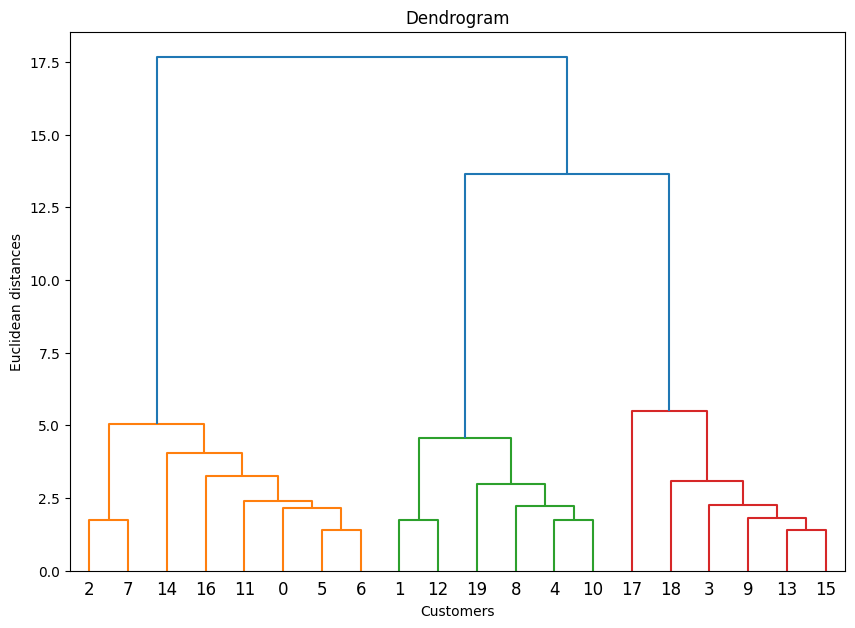


The Elbow Method for KMeans:
Mục tiêu: Tìm số cụm k tại đó sự giảm của WCSS bắt đầu “chậm lại” đáng kể. Điểm này thường được gọi là “khuỷu tay” (elbow).


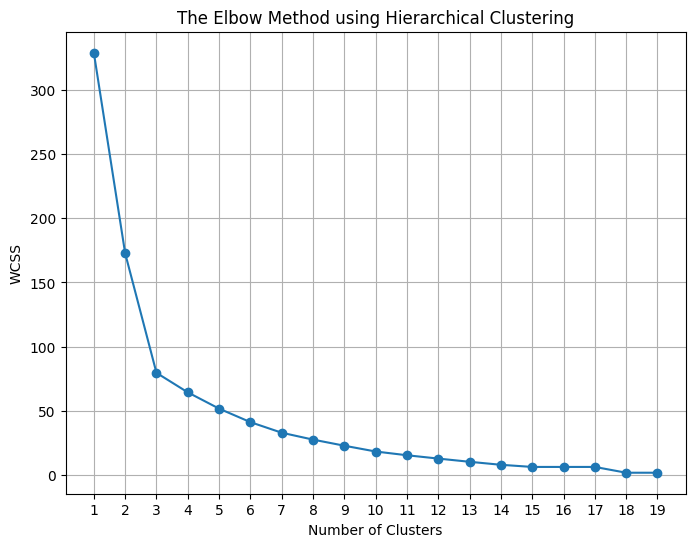


Silhouette Analysis:
Mục tiêu: Mean Silhouette Score càng cao thì cụm càng chất lượng.


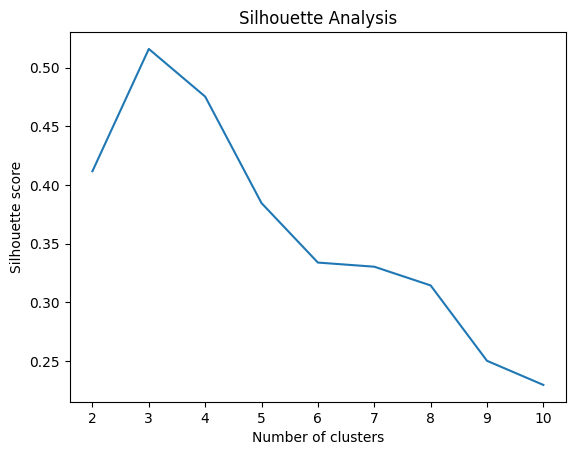


Optimal number of clusters: 3

Hierarchical clustering model:

    v1  v2  v3  v4  v5  v6  hierarchical_clustering
0    6   4   7   3   2   3                        1
1    2   3   1   4   5   4                        2
2    7   2   6   4   1   3                        1
3    4   6   4   5   3   6                        0
4    1   3   2   2   6   4                        2
5    6   4   6   3   3   4                        1
6    5   3   6   3   3   4                        1
7    7   3   7   4   1   4                        1
8    2   4   3   3   6   3                        2
9    3   5   3   6   4   6                        0
10   1   3   2   3   5   3                        2
11   5   4   5   4   2   4                        1
12   2   2   1   5   4   4                        2
13   4   6   4   6   4   7                        0
14   6   5   4   2   1   4                        1
15   3   5   4   6   4   7                        0
16   4   4   7   2   2   5                        1


,v1,v2,v3,v4,v5,v6
hierarchical_clustering,,,,,,
0,3.500000,5.833333,3.333333,6.000000,3.500000,6.000000
1,5.750000,3.625000,6.000000,3.125000,1.875000,3.875000
2,1.666667,3.000000,1.833333,3.500000,5.500000,3.333333


In [116]:
# Create dendrogram
print('Dendrogram:')
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(cluster_data, method='ward', metric='euclidean')) # You can change the linkage method
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()
print()

print('The Elbow Method for KMeans:')
print('Mục tiêu: Tìm số cụm k tại đó sự giảm của WCSS bắt đầu “chậm lại” đáng kể. Điểm này thường được gọi là “khuỷu tay” (elbow).')
# Tính toán linkage matrix
Z = linkage(cluster_data, method='ward')  # Phương pháp 'ward' tối ưu WCSS
# Hàm tính WCSS
def calculate_wcss(data, Z, max_clusters=19): # input max_clusters
    wcss = []
    for k in range(1, max_clusters + 1):
        labels = fcluster(Z, t=k, criterion='maxclust')
        wcss_k = 0
        for cluster in np.unique(labels):
            cluster_points = data[labels == cluster]
            centroid = cluster_points.mean(axis=0)
            wcss_k += np.sum((cluster_points - centroid) ** 2)
        wcss.append(wcss_k)
    return wcss
# Tính WCSS
max_clusters = 19 # input max_clusters
wcss = calculate_wcss(np.array(cluster_data), Z, max_clusters=max_clusters)
# Vẽ biểu đồ Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-')
plt.title('The Elbow Method using Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()
print()

# Silhouette analysis
print('Silhouette Analysis:')
print('Mục tiêu: Mean Silhouette Score càng cao thì cụm càng chất lượng.')
silhouette_scores = []
for n_clusters in range(2, 11): # Test different numbers of clusters
    # Remove 'affinity='euclidean'' as it's not needed with linkage='ward'
    hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = hc.fit_predict(cluster_data)
    silhouette_avg = silhouette_score(cluster_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()
print()

# Based on the elbow method and silhouette analysis, choose the optimal n_clusters
optimal_n_clusters = 3  # Replace with the value you determine from the plots
print(f"Optimal number of clusters: {optimal_n_clusters}")
print()

# Fit hierarchical clustering model
print('Hierarchical clustering model:')
print()
hc = AgglomerativeClustering(n_clusters=optimal_n_clusters, metric='euclidean', linkage='ward')
y_hc = hc.fit_predict(cluster_data)
# Add cluster labels to the DataFrame
cluster_data['hierarchical_clustering'] = y_hc
# Display the clustered data
print(cluster_data)
print()

# Average result of each variable by cluster
print('Average result of each variable by cluster:')
cluster_means = cluster_data.groupby('hierarchical_clustering').mean()
cluster_means
def highlight_max(s):
    is_max = s == np.nanmax(s)
    return ['background-color: blue' if v else '' for v in is_max]
def create_cluster_summary(cluster_data):
    cluster_means = cluster_data.groupby('cluster').mean()
    styled_means = cluster_means.style.apply(highlight_max, axis=1)
    return styled_means
# Assuming 'cluster_data' DataFrame is already created as in your original code.
styled_cluster_means = cluster_means.style.apply(highlight_max, axis=1)
styled_cluster_means

# 5. K-means (Phân tích cụm không thứ bậc)

In [117]:
cluster_data.drop(columns=['hierarchical_clustering'], inplace=True)

The Elbow Method for KMeans:
Mục tiêu: Tìm số cụm k tại đó sự giảm của WCSS bắt đầu “chậm lại” đáng kể. Điểm này thường được gọi là “khuỷu tay” (elbow).


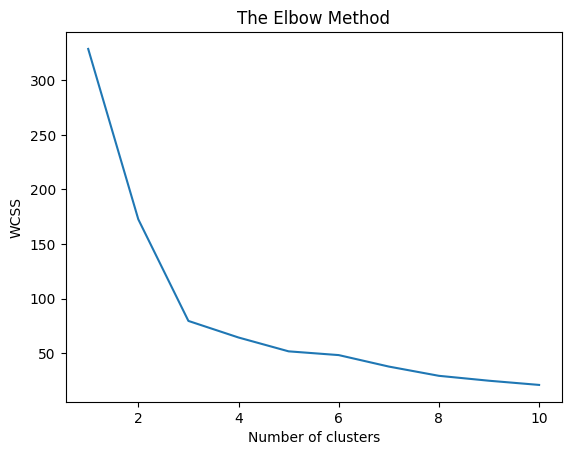


Silhouette Analysis for KMeans:
Mục tiêu: Mean Silhouette Score càng cao thì cụm càng chất lượng.


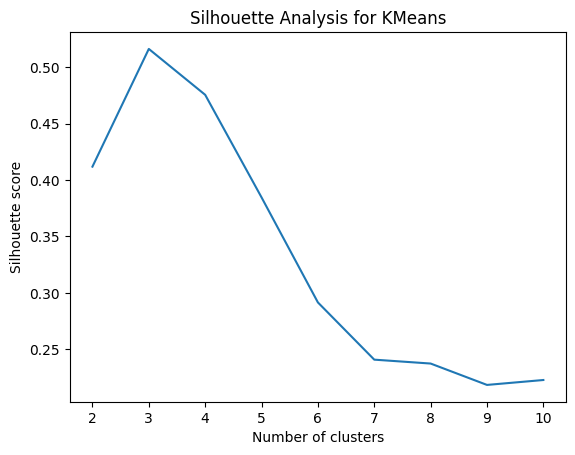


KMeans Model:
    v1  v2  v3  v4  v5  v6  cluster_kmeans
0    6   4   7   3   2   3               0
1    2   3   1   4   5   4               2
2    7   2   6   4   1   3               0
3    4   6   4   5   3   6               1
4    1   3   2   2   6   4               2
5    6   4   6   3   3   4               0
6    5   3   6   3   3   4               0
7    7   3   7   4   1   4               0
8    2   4   3   3   6   3               2
9    3   5   3   6   4   6               1
10   1   3   2   3   5   3               2
11   5   4   5   4   2   4               0
12   2   2   1   5   4   4               2
13   4   6   4   6   4   7               1
14   6   5   4   2   1   4               0
15   3   5   4   6   4   7               1
16   4   4   7   2   2   5               0
17   3   7   2   6   4   3               1
18   4   6   3   7   2   7               1
19   2   3   2   4   7   2               2

Average result of each variable by cluster (KMeans):


,v1,v2,v3,v4,v5,v6
cluster_kmeans,,,,,,
0,5.750000,3.625000,6.000000,3.125000,1.875000,3.875000
1,3.500000,5.833333,3.333333,6.000000,3.500000,6.000000
2,1.666667,3.000000,1.833333,3.500000,5.500000,3.333333


In [118]:
# Determine optimal number of clusters using the Elbow method for KMeans
print('The Elbow Method for KMeans:')
print('Mục tiêu: Tìm số cụm k tại đó sự giảm của WCSS bắt đầu “chậm lại” đáng kể. Điểm này thường được gọi là “khuỷu tay” (elbow).')
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(cluster_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
print()

# Silhouette analysis for KMeans
print('Silhouette Analysis for KMeans:')
print('Mục tiêu: Mean Silhouette Score càng cao thì cụm càng chất lượng.')
silhouette_scores_kmeans = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(cluster_data)
    silhouette_avg = silhouette_score(cluster_data, cluster_labels)
    silhouette_scores_kmeans.append(silhouette_avg)
plt.plot(range(2, 11), silhouette_scores_kmeans)
plt.title('Silhouette Analysis for KMeans')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()
print()

# Apply KMeans clustering with the optimal number of clusters
print('KMeans Model:')
optimal_n_clusters_kmeans = 3 # Replace with your optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters_kmeans, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(cluster_data)
# Add cluster labels to the DataFrame
cluster_data['cluster_kmeans'] = y_kmeans
# Display the clustered data
print(cluster_data)
print()

# Analyze the clusters
print('Average result of each variable by cluster (KMeans):')
cluster_means_kmeans = cluster_data.groupby('cluster_kmeans').mean()
styled_cluster_means_kmeans = cluster_means_kmeans.style.apply(highlight_max, axis=1)
styled_cluster_means_kmeans